# Construct near-terminus surface elevation time series

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import rioxarray as rxr
import xarray as xr
import rasterio as rio
import numpy as np
import datetime
from tqdm.auto import tqdm
from matplotlib.cm import ScalarMappable
import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import LineString
import xdem
import pyproj
import geoutils as gu

/Users/rdcrlrka/.local/share/mamba/envs/hubbard/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define paths to data files

In [2]:
# Path to "data" in local directory, meant to mimic the shared Google Drive "data" folder
data_path = "/Volumes/LaCie/raineyaberle/Research/Hubbard/data" 

# Bed topography
bed_file = os.path.join(data_path, "bed_topo", 'Hubbard_IfSAR_Bathy_Millan_Icebridge.tiff')

# Centerline
center_file = os.path.join(data_path, 'velocity', 'center.gpkg')

# Glacier boundaries 
aoi_clipped_file = os.path.join(data_path, 'RGI60-01.14443_outline_clipped.gpkg')

# DEMs
arcticdem_files = sorted(glob.glob(os.path.join(data_path, "DEMs", "mosaics", "*.tif")))
print(f"Located {len(arcticdem_files)} DEM mosaics.")

# Outputs
out_crs = "EPSG:3338" # Alaska Albers
figures_out_path = os.path.join(data_path, "..", "Figures") # where figures will be saved
h_out_path = os.path.join(data_path, "DEMs") # where centerline elevations will be saved

Located 99 DEM mosaics.


## Create a map of number of observations to select some sample regions

In [3]:
# Define output file name
obs_count_file = os.path.join(h_out_path, "observations_count.tif")

# Load the clipped AOI
aoi_clipped = gpd.read_file(aoi_clipped_file)

if not os.path.exists(obs_count_file):

    # --- Create grid of zeros ---
    # Define the grid
    minx, miny, maxx, maxy = aoi_clipped.total_bounds
    resolution = 10
    x = np.arange(minx, maxx, resolution)
    y = np.arange(miny, maxy, resolution)
    coords = {
        'y': y,
        'x': x
    }
    dims = ('y', 'x')
    
    # Create the xarray Dataset of zeros
    empty_data = np.empty((len(y), len(x)))
    empty_data[:] = 0
    obs_count = xr.Dataset(
        data_vars={'num_obs': (dims, empty_data)},
        coords=coords,
    ).astype(int)
    obs_count = obs_count.rio.write_crs(aoi_clipped.crs)
    
    # --- Count total number of observations at each pixel ---
    # Iterate over DEMs
    for dem_file in tqdm(arcticdem_files):
        # load the DEM
        dem = rxr.open_rasterio(dem_file).squeeze()
        # reproject to match the grid
        dem = dem.rio.reproject_match(obs_count)
        # create mask where data values exist
        dem_obs_count = xr.where(dem==dem.attrs["_FillValue"], 0, 1).astype(int)
        # add to the grid of zeros
        obs_count += dem_obs_count
    
    # --- Save to file ---
    obs_count = obs_count.rio.write_crs(aoi_clipped.crs)
    obs_count.rio.to_raster(
        obs_count_file,
        dtype="uint8",
        driver="GTiff"
    )
    print(f"Observation counts saved to: {obs_count_file}")

else:
    obs_count = rxr.open_rasterio(obs_count_file).squeeze()
    print("Observation counts loaded from file.")


Observation counts loaded from file.


## Plot and select sample regions

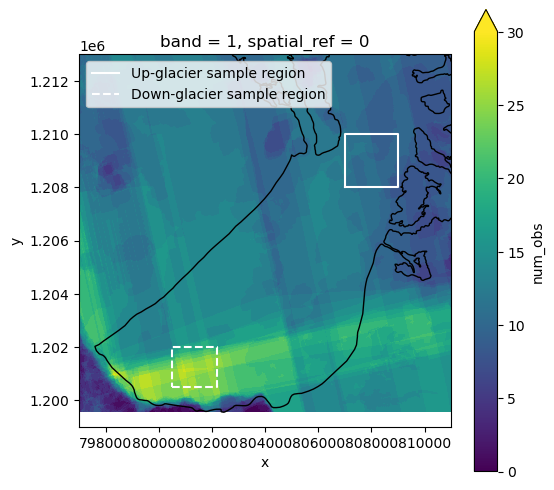

In [4]:
# Define the sample regions
up_region = (807e3, 809e3, 1208e3, 1210e3)
down_region = (800.5e3, 802.2e3, 1200.5e3, 1202e3)

# Plot
fig, ax = plt.subplots(figsize=(6,6))
obs_count.plot(ax=ax, vmin=0, vmax=30)
aoi_clipped.plot(ax=ax, facecolor="None", edgecolor="k")
ax.plot(
    [up_region[0], up_region[1], up_region[1], up_region[0], up_region[0]],
    [up_region[2], up_region[2], up_region[3], up_region[3], up_region[2]],
    '-', color="w", label="Up-glacier sample region"
)
ax.plot(
    [down_region[0], down_region[1], down_region[1], down_region[0], down_region[0]],
    [down_region[2], down_region[2], down_region[3], down_region[3], down_region[2]],
    '--', color="w", label="Down-glacier sample region"
)
ax.set_xlim(797e3, 811e3)
ax.set_ylim(1199e3, 1213e3)
ax.legend(loc="upper left")
plt.show()

## Sample DEMs at each region

In [5]:
# Define output file
dem_samples_file = os.path.join(h_out_path, "DEM_samples.csv")
if os.path.exists(dem_samples_file):
    dem_samples_df = pd.read_csv(dem_samples_file)
    print("DEM samples loaded from file.")

else:

    # Initialize variables
    dates = np.empty(len(arcticdem_files), dtype="U25")
    up_glacier_means = np.zeros(len(arcticdem_files))
    down_glacier_means = np.zeros(len(arcticdem_files))

    # Iterate over DEMs
    for i, dem_file in enumerate(tqdm(arcticdem_files)):
        # Grab date from file name
        date = os.path.basename(dem_file).split("_")[0]
        date = f"{date[0:4]}-{date[4:6]}-{date[6:]}"

        # Load DEM
        dem = rxr.open_rasterio(dem_file).squeeze()
        crs = dem.rio.crs
        dem = xr.where(dem==dem.attrs["_FillValue"], np.nan, dem)
        dem = dem.rio.write_crs(crs)
        dem = dem.rio.reproject_match(obs_count)

        try:                
            dem_up_sample = np.nanmean(dem.sel(
                x=slice(up_region[0], up_region[1]), 
                y=slice(up_region[2], up_region[3]),
            ).values)
            
            dem_down_sample = np.nanmean(dem.sel(
                x=slice(down_region[0], down_region[1]), 
                y=slice(down_region[2], down_region[3]),
            ).values)

            dates[i] = date
            up_glacier_means[i] = dem_up_sample
            down_glacier_means[i] = dem_down_sample
        except:
            dates[i] = date
            up_glacier_means[i] = np.nan
            down_glacier_means[i] = np.nan
            continue

    # Compile in dataframe
    dem_samples_df = pd.DataFrame({
        "date": dates,
        "up_glacier_mean": up_glacier_means,
        "down_glacier_mean": down_glacier_means
    })

    # Save to file
    dem_samples_df.to_csv(dem_samples_file, index=False)
    print(f"DEM samples saved to: {dem_samples_file}")

# Preprocessing...
# Remove the one wacky value
dem_samples_df.loc[dem_samples_df["down_glacier_mean"] > 1e3, "down_glacier_mean"] = np.nan
# Remove rows with all NaNs
dem_samples_df.dropna(subset=["up_glacier_mean", "down_glacier_mean"], how='all', inplace=True)
# Demean
dem_samples_df["up_glacier_mean_demeaned"] = dem_samples_df["up_glacier_mean"] - np.nanmean(dem_samples_df["up_glacier_mean"])
dem_samples_df["down_glacier_mean_demeaned"] = dem_samples_df["down_glacier_mean"] - np.nanmean(dem_samples_df["down_glacier_mean"])
# Convert date string to datetime object
dem_samples_df["date"] = pd.to_datetime(dem_samples_df["date"])
# Add DOY column
dem_samples_df["DOY"] = dem_samples_df["date"].dt.dayofyear
dem_samples_df

DEM samples loaded from file.


,date,up_glacier_mean,down_glacier_mean,up_glacier_mean_demeaned,down_glacier_mean_demeaned,DOY
0,2013-05-22,547.713928,172.153076,7.571129,18.842018,142
1,2013-05-26,NaN,173.931473,NaN,20.620415,146
3,2013-06-16,NaN,168.745087,NaN,15.434029,167
5,2013-06-25,NaN,162.532928,NaN,9.221871,176
6,2013-08-10,538.126587,171.151260,-2.016212,17.840203,222
7,2013-12-07,NaN,154.544434,NaN,1.233376,341
12,2014-11-11,545.882874,NaN,5.740075,NaN,315
14,2014-11-20,NaN,141.932755,NaN,-11.378303,324
16,2015-10-31,503.678894,152.778641,-36.463905,-0.532417,304
19,2016-03-22,NaN,153.181580,NaN,-0.129478,82


## Plot results

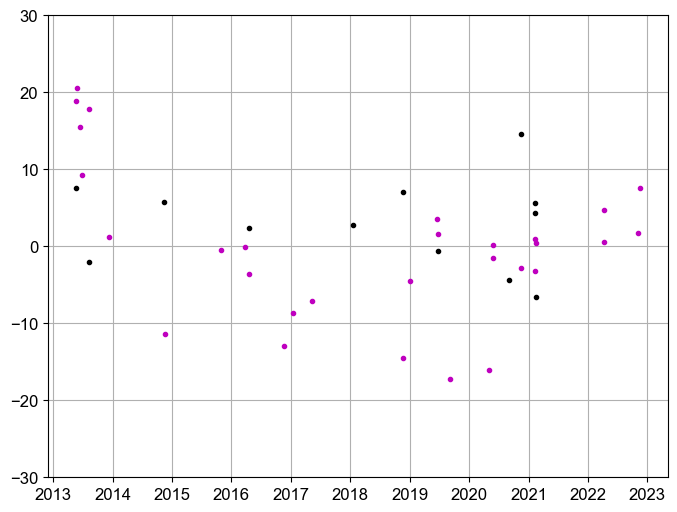

In [6]:
# --- Full time series ---
plt.rcParams.update({"font.size": 12, "font.sans-serif": "Arial"})
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(dem_samples_df["date"], dem_samples_df["up_glacier_mean_demeaned"], '.k')
ax.plot(dem_samples_df["date"], dem_samples_df["down_glacier_mean_demeaned"], '.m')
ax.set_ylim(-30,30)
ax.grid()
plt.show()

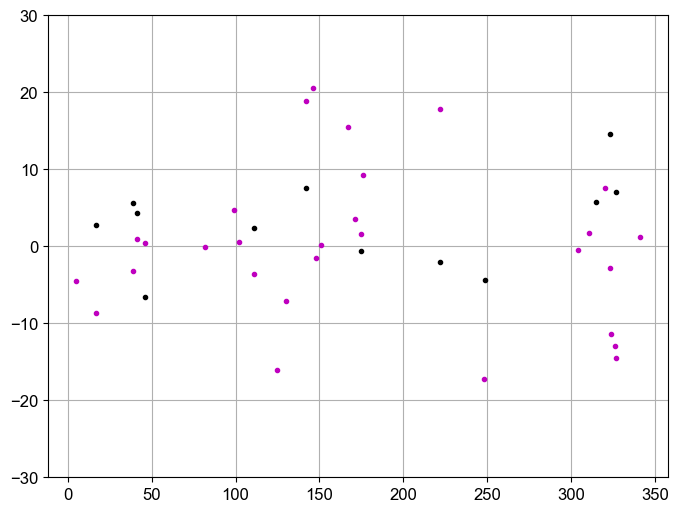

In [7]:
# --- Plot by DOY ---
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(dem_samples_df["DOY"], dem_samples_df["up_glacier_mean_demeaned"], '.k')
ax.plot(dem_samples_df["DOY"], dem_samples_df["down_glacier_mean_demeaned"], '.m')
ax.set_ylim(-30,30)
ax.grid()
plt.show()


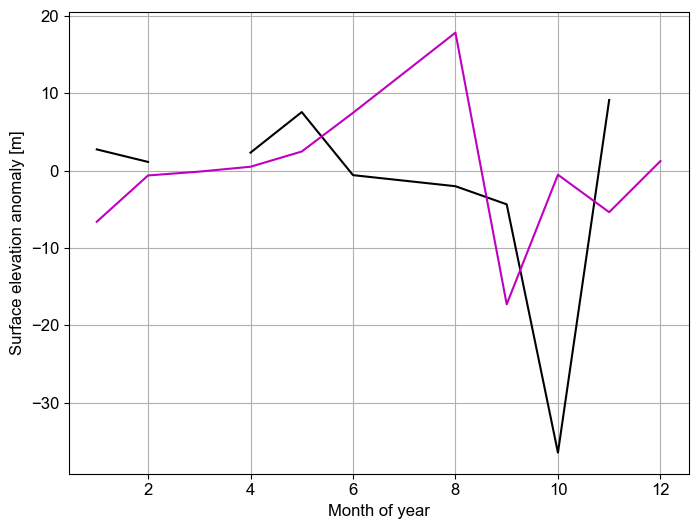

In [8]:
# --- Plot monthly median ---
dem_samples_df["month"] = dem_samples_df["date"].dt.month
fig, ax = plt.subplots(1, 1, figsize=(8,6))
dem_samples_df.groupby("month")["up_glacier_mean_demeaned"].mean().plot(ax=ax, color='k')
dem_samples_df.groupby("month")["down_glacier_mean_demeaned"].mean().plot(ax=ax, color='m')
ax.grid()
ax.set_xlabel("Month of year")
ax.set_ylabel("Surface elevation anomaly [m]")
plt.show()

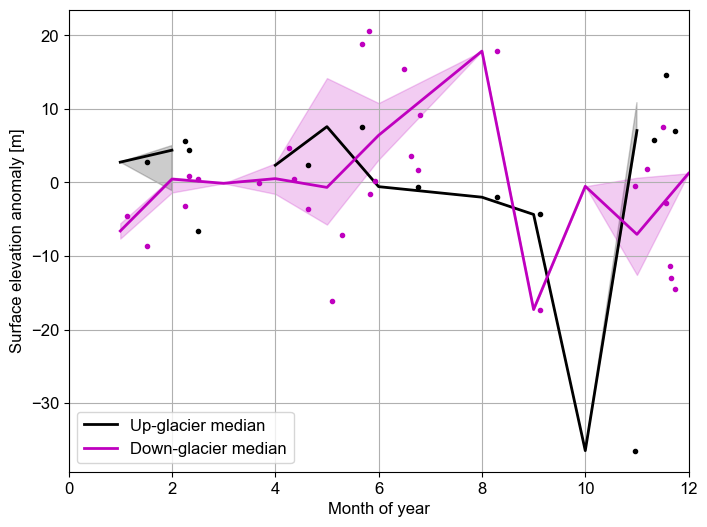

In [9]:
# --- Plot median + IQR by month of year ---

# Add decimal month column for plotting raw observations in their correct place (not just integer months)
month = dem_samples_df['date'].dt.month
day = dem_samples_df['date'].dt.day
days_in_month = dem_samples_df['date'].dt.days_in_month
dem_samples_df['decimal_month'] = month + (day - 1) / days_in_month


# Calculate monthly medians and IQRs
grouped_by_month = dem_samples_df.groupby('month')

up_median = grouped_by_month['up_glacier_mean_demeaned'].median()
up_q1 = grouped_by_month['up_glacier_mean_demeaned'].quantile(0.25)
up_q3 = grouped_by_month['up_glacier_mean_demeaned'].quantile(0.75)

down_median = grouped_by_month['down_glacier_mean_demeaned'].median()
down_q1 = grouped_by_month['down_glacier_mean_demeaned'].quantile(0.25)
down_q3 = grouped_by_month['down_glacier_mean_demeaned'].quantile(0.75)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

ax.fill_between(up_q1.index, up_q1, up_q3, color='k', alpha=0.2)#, label="Up-glacier IQR")
ax.plot(up_median.index, up_median, color='k', linewidth=2, label='Up-glacier median')
ax.fill_between(down_q1.index, down_q1, down_q3, color='m', alpha=0.2)#, label="Down-glacier IQR")
ax.plot(down_median.index, down_median, color='m', linewidth=2, label='Down-glacier median')

ax.plot(dem_samples_df["decimal_month"], dem_samples_df["up_glacier_mean_demeaned"], '.k')
ax.plot(dem_samples_df["decimal_month"], dem_samples_df["down_glacier_mean_demeaned"], '.m')

ax.grid()
ax.set_xlim(0,12)
ax.set_ylabel("Surface elevation anomaly [m]")
ax.set_xlabel("Month of year")
ax.legend(loc="lower left")

plt.show()



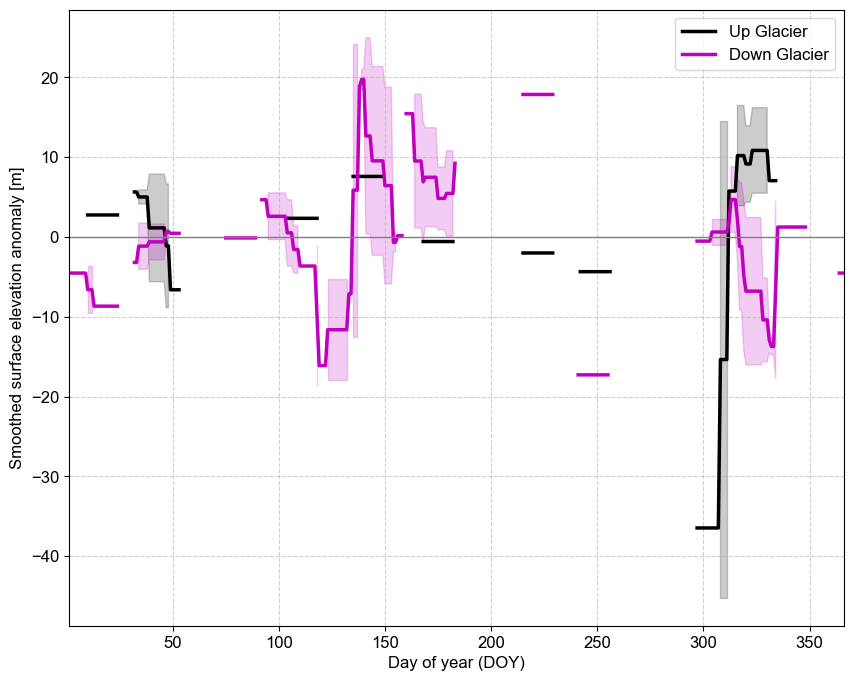

In [10]:
# --- Plot rolling mean and std ---
dem_samples_df['doy'] = dem_samples_df['date'].dt.dayofyear

# Create a daily-averaged dataset
daily_avg = dem_samples_df.groupby('doy')[['up_glacier_mean_demeaned', 'down_glacier_mean_demeaned']].mean()

# Resample to a full 1-366 day timeline
full_year_index = range(1, 367)
daily_avg = daily_avg.reindex(full_year_index)

# Define the rolling window size in days
window_days = 15 

# Handle year wrap-arounds
extended_daily_avg = pd.concat([
    daily_avg.iloc[-window_days:], # End of last year
    daily_avg,                     # Current year
    daily_avg.iloc[:window_days]   # Start of next year
])

# Calculate the rolling mean
rolling_mean = extended_daily_avg.rolling(
    window=window_days, 
    center=True,
    min_periods=1
).mean()

# Calculate the rolling standard deviation
rolling_std = extended_daily_avg.rolling(
    window=window_days, 
    center=True,
    min_periods=1
).std()

# Trim back to a single year's length
rolling_mean = rolling_mean.iloc[window_days:-window_days]
rolling_std = rolling_std.iloc[window_days:-window_days]

# Plot the results
fig, ax = plt.subplots(figsize=(10, 8))
for region, color in [('up_glacier', 'k'), ('down_glacier', 'm')]:
    mean_col = f'{region}_mean_demeaned'
    
    mean_curve = rolling_mean[mean_col]
    std_curve = rolling_std[mean_col]
    
    upper_bound = mean_curve + std_curve
    lower_bound = mean_curve - std_curve
    
    ax.plot(mean_curve.index, mean_curve, color=color, linewidth=2.5, label=f'{region.replace("_", " ").title()}')
    ax.fill_between(mean_curve.index, lower_bound, upper_bound, color=color, alpha=0.2)

ax.grid(True, linestyle='--', alpha=0.6)
ax.axhline(0, color='gray', linewidth=1)
ax.set_xlabel("Day of year (DOY)")
ax.set_ylabel("Smoothed surface elevation anomaly [m]")
ax.legend()
ax.set_xlim(1, 366)
plt.show()
